In [1]:
 # Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

In [2]:
df_train = pd.read_csv(os.path.join(DATA_PATH, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATA_PATH, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

In [3]:
# Listas de características con una correlación mayor que 0.38

useful_features = ['generation_hydro_pumped_storage_consumption',
       'generation_fossil_gas', 'generation_fossil_oil',
       'generation_hydro_water_reservoir', 'price_actual', 'hour',
       'generation_fossil_hard_coal', 'generation_solar']

In [4]:
# intento crear una nueva característica sumando todas las generaciones:

generations = ['generation_biomass', 'generation_fossil_brown_coal_lignite','generation_fossil_gas',
               'generation_fossil_hard_coal', 'generation_fossil_oil',
               'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage',
               'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other',
               'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore']

new_features_train = pd.DataFrame(index = df_train.index)

new_features_train["Consumo_MW"] = df_train["Consumo_MW"]
new_features_train["total_generation"] = df_train[generations[0]]

for i in range(1,len(generations)):
    
    new_features_train["total_generation"] +=  df_train[generations[i]]

# Creo una nueva feture multiplicando el valor del EUR/MW por el total de MW usados

new_features_train["money_spent"] = new_features_train["total_generation"]*df_train["price_actual"]



array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>], dtype=object)

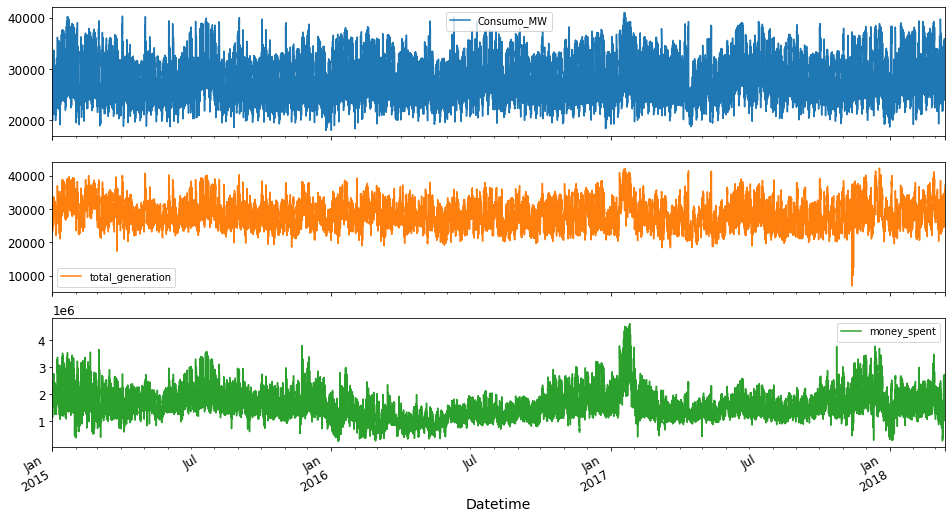

In [5]:
new_features_train.plot(subplots = True, figsize = (16, 9))

# Añado las nuevas características a train y test, y elimino las no deseadas

In [6]:
df_train["total_generation"] = new_features_train["total_generation"]
df_train["money_spent"] = new_features_train["money_spent"]


df_train_shifted = pd.DataFrame(df_train["Consumo_MW"])
df_train_shifted[df_train.columns[1:]] = df_train[df_train.columns[1:]].shift(24)
df_train_shifted = df_train_shifted.dropna()

# Ordeno las correlaciones con valor absoluto en un dataframe

columnas = df_train_shifted.columns

correlaciones_train_df = pd.DataFrame(df_train_shifted.corr(method = "pearson").loc["Consumo_MW"])

correlaciones_ordenadas = abs(correlaciones_train_df).sort_values("Consumo_MW", ascending = False)

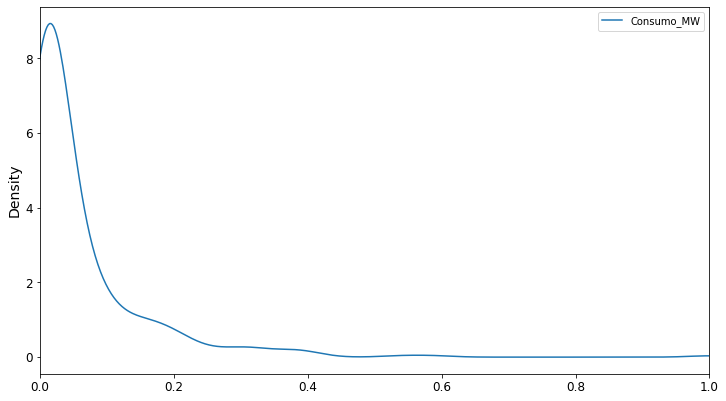

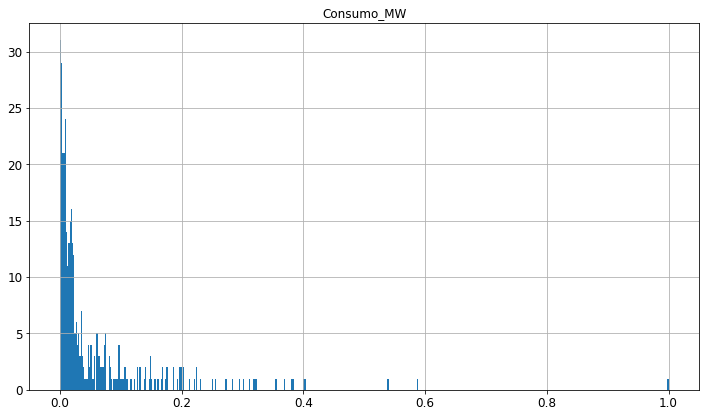

In [79]:
correlaciones_ordenadas[:].plot(kind = "density", figsize = (12, 6.75), xlim = [0.,1.])
correlaciones_ordenadas[:].hist(bins = 500, figsize = (12, 6.75))
plt.show()

In [100]:
print("Total: ", correlaciones_ordenadas.shape[0], "\n",
    "< 0.3: ", correlaciones_ordenadas[correlaciones_ordenadas[:]< 0.3].count()[0], "\n",
    "< 0.2: ", correlaciones_ordenadas[correlaciones_ordenadas[:]< 0.2].count()[0], "\n",
    "< 0.1: ", correlaciones_ordenadas[correlaciones_ordenadas[:]< 0.1].count()[0])

Total:  381 
 < 0.3:  367 
 < 0.2:  354 
 < 0.1:  314


#### Veo que las nuevas carcterísticas son buenas para el problema deseado

In [8]:
#modifico el test set 

new_features_test = pd.DataFrame(index = df_test.index)

new_features_test["Consumo_MW"] = df_test["Consumo_MW"]
new_features_test["total_generation"] = df_test[generations[0]]

for i in range(1,len(generations)):
    
    new_features_test["total_generation"] +=  df_test[generations[i]]
    
new_features_test["money_spent"] = new_features_test["total_generation"]*df_test["price_actual"]

# Elimino características no deseadas

df_test["total_generation"] = new_features_test["total_generation"]
df_test["money_spent"] = new_features_test["money_spent"]

useful_features = ['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', "Consumo_MW"]

columnas = df_train.columns

for i in range(len(columnas)): # Elimino columnas no deseadas
    
    feature = columnas[i]
    if feature not in useful_features:
        
        df_train.drop([feature], axis = 1, inplace = True)
        df_test.drop([feature], axis = 1, inplace = True)


df_train = df_train.reindex(columns = ['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', "Consumo_MW"])
df_test = df_test.reindex(columns = ['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', "Consumo_MW"])

In [13]:
print(correlaciones_ordenadas[:25].to_latex(buf=None, columns=None, col_space=None, header=True,
                                            index=True, na_rep='NaN', formatters=None, float_format=None,
                                            sparsify=None, index_names=True, bold_rows=False, column_format=None,
                                            longtable=None, escape=None, encoding=None, decimal='.',
                                            multicolumn=None, multicolumn_format=None, multirow=None,
                                            caption=None, label=None))
      
      

\begin{tabular}{lr}
\toprule
{} &  Consumo\_MW \\
\midrule
Consumo\_MW                                  &    1.000000 \\
total\_generation                            &    0.587352 \\
money\_spent                                 &    0.539402 \\
hour                                        &    0.402400 \\
generation\_hydro\_pumped\_storage\_consumption &    0.400341 \\
price\_actual                                &    0.382460 \\
generation\_solar                            &    0.380802 \\
generation\_fossil\_gas                       &    0.369779 \\
x14\_01d                                     &    0.355955 \\
x12\_01n                                     &    0.322905 \\
generation\_hydro\_water\_reservoir            &    0.321609 \\
x14\_01n                                     &    0.319559 \\
humidity\_Va                                 &    0.311885 \\
humidity\_Ba                                 &    0.301336 \\
x12\_01d                                     &    0.295453 \\
humidi

In [14]:
df_train.columns.size, df_train.columns, df_test.columns

(14, Index(['total_generation', 'money_spent', 'hour',
        'generation_hydro_pumped_storage_consumption', 'price_actual',
        'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
        'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
        'humidity_Ba', 'Consumo_MW'],
       dtype='object'), Index(['total_generation', 'money_spent', 'hour',
        'generation_hydro_pumped_storage_consumption', 'price_actual',
        'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
        'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
        'humidity_Ba', 'Consumo_MW'],
       dtype='object'))

In [15]:
df_train

,total_generation,money_spent,hour,generation_hydro_pumped_storage_consumption,price_actual,generation_solar,generation_fossil_gas,x14_01d,x12_01n,generation_hydro_water_reservoir,x14_01n,humidity_Va,humidity_Ba,Consumo_MW
Datetime,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,28251.0,1847897.91,23,863.0,65.41,49.0,4844.0,0.0,1.0,1899.0,1.0,77,100,25385.0
2015-01-01 00:00:00+00:00,27818.0,1805944.56,0,920.0,64.92,50.0,5196.0,0.0,1.0,1658.0,1.0,77,100,24382.0
2015-01-01 01:00:00+00:00,26796.0,1727806.08,1,1164.0,64.48,50.0,4857.0,0.0,1.0,1371.0,1.0,78,100,22734.0
2015-01-01 02:00:00+00:00,25223.0,1496228.36,2,1503.0,59.32,50.0,4314.0,0.0,1.0,779.0,1.0,78,100,21286.0
2015-01-01 03:00:00+00:00,24620.0,1379704.80,3,1826.0,56.04,42.0,4130.0,0.0,1.0,720.0,1.0,78,100,20264.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-14 13:00:00+00:00,34772.0,1590471.28,13,211.0,45.74,1083.0,4144.0,0.0,0.0,5220.0,0.0,45,55,34230.0
2018-03-14 14:00:00+00:00,35734.0,1447584.34,14,1080.0,40.51,994.0,4039.0,0.0,0.0,5360.0,0.0,45,59,33636.0
2018-03-14 15:00:00+00:00,36030.0,1252402.80,15,1272.0,34.76,716.0,4056.0,0.0,0.0,5567.0,0.0,52,59,33116.0


# Empiezo a preparar las series temporales

In [16]:
df_train.columns[-1]

'Consumo_MW'

In [17]:
#Creo dataframes de test y train para las características y para los targets


# Training set

targets = df_train.columns[-1]
features = df_train.columns[:]

features_df = df_train[features]
targets_df = pd.DataFrame(df_train[targets])

# Creo varios targets: y+1, y+2, ...., y+24

for i in range(1,25):

    aux_df = pd.DataFrame(targets_df["Consumo_MW"].shift(-i))
    aux_str = "y + "+str(i)
    targets_df[aux_str] = aux_df["Consumo_MW"]

X_Y_df_train = features_df.copy().drop(["Consumo_MW"], axis = 1, inplace = False).join(targets_df.copy())
#X_Y_df # Contiene los dataframes de X e Y


# Test set

targets = df_test.columns[-1]
features = df_test.columns[:]

features_df = df_test[features]
targets_df = pd.DataFrame(df_test[targets])

for i in range(1,25):

    aux_df = pd.DataFrame(targets_df["Consumo_MW"].shift(-i))
    aux_str = "y + "+str(i)
    targets_df[aux_str] = aux_df["Consumo_MW"]

X_Y_df_test = features_df.copy().drop(["Consumo_MW"], axis = 1, inplace = False).join(targets_df.copy())


# Guardo los datasets

X_Y_df_train.to_csv(os.path.join(DATASETS, "df_train.csv"), index = True)
X_Y_df_test.to_csv(os.path.join(DATASETS, "df_test.csv"), index = True)

# Examino correlaciones respecto de instantes posteriores

In [24]:
nuevas_correlaciones = pd.DataFrame(
    X_Y_df_train.corr(method = "pearson").loc[X_Y_df_train.columns.to_list()[:-24]].iloc[:,-25:])

nuevas_correlaciones_ordenadas = abs(nuevas_correlaciones).sort_values("Consumo_MW", ascending = False)

In [103]:
nuevas_correlaciones_ordenadas

,Consumo_MW,y + 1,y + 2,y + 3,y + 4,y + 5,y + 6,y + 7,y + 8,y + 9,...,y + 15,y + 16,y + 17,y + 18,y + 19,y + 20,y + 21,y + 22,y + 23,y + 24
Consumo_MW,1.000000,0.950864,0.832557,0.675662,0.505561,0.343754,0.207627,0.107235,0.045875,0.017854,...,0.077152,0.075393,0.037788,0.039539,0.152191,0.290145,0.437195,0.571309,0.668346,0.702691
total_generation,0.832021,0.792994,0.711480,0.604754,0.486367,0.368283,0.259990,0.168410,0.097308,0.045547,...,0.045361,0.011089,0.045812,0.122719,0.214448,0.314756,0.415288,0.504830,0.567520,0.587352
money_spent,0.699573,0.669931,0.587061,0.471276,0.342709,0.220702,0.120241,0.049234,0.008938,0.004378,...,0.001700,0.000810,0.024375,0.073178,0.145946,0.237024,0.337422,0.433565,0.507868,0.539402
generation_hydro_pumped_storage_consumption,0.581571,0.545633,0.450358,0.320028,0.181703,0.059975,0.026994,0.072137,0.078944,0.058173,...,0.081690,0.112799,0.108793,0.061136,0.025079,0.134298,0.244983,0.335899,0.391582,0.400341
generation_fossil_gas,0.543424,0.528566,0.477136,0.401610,0.315405,0.229820,0.154682,0.098379,0.065836,0.055657,...,0.082126,0.074938,0.077954,0.095112,0.128067,0.175662,0.233724,0.294396,0.344477,0.369779
generation_hydro_water_reservoir,0.474881,0.457010,0.380034,0.270393,0.150910,0.041380,0.042546,0.092212,0.105187,0.088021,...,0.066692,0.097962,0.111957,0.100406,0.060194,0.006810,0.094371,0.190367,0.275372,0.321609
price_actual,0.452951,0.435252,0.370227,0.275265,0.169648,0.072293,0.001937,0.046143,0.060321,0.048633,...,0.008352,0.007614,0.007253,0.016656,0.064914,0.132823,0.212142,0.290385,0.353180,0.382460
hour,0.402407,0.254975,0.081249,0.104291,0.288484,0.443032,0.537149,0.561426,0.529147,0.456043,...,0.073383,0.120795,0.170588,0.239085,0.334528,0.447354,0.531807,0.551006,0.505219,0.402400
generation_solar,0.381788,0.365878,0.347464,0.326779,0.298371,0.257767,0.200368,0.121241,0.017651,0.108757,...,0.563473,0.463229,0.323449,0.162233,0.001505,0.149725,0.266455,0.342133,0.377208,0.380802
x14_01d,0.353554,0.369249,0.355893,0.315655,0.252308,0.171134,0.083459,0.003451,0.085385,0.159379,...,0.288084,0.230898,0.157255,0.072855,0.016993,0.105918,0.189919,0.259830,0.313497,0.355955


## Uso un mapa de calor vara visualizarlo

Saving figure heatmap2


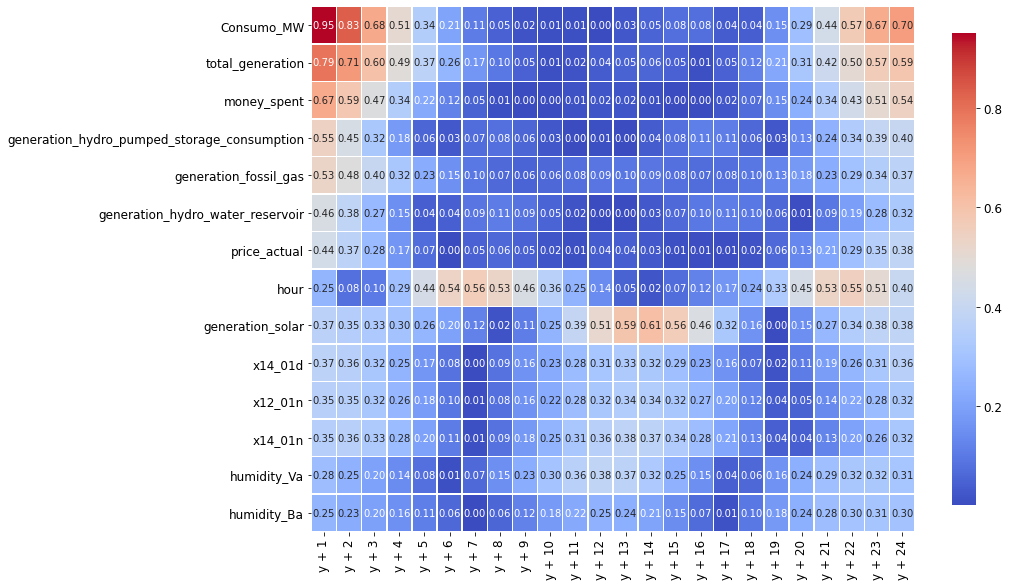

In [106]:
# Diferentes colorespara los mapas de mapas de calor:
#          cmap = "coolwarm", # cmap = "YlGnBu"

fig, ax = plt.subplots(figsize=(15, 8.25)) 
mapa_de_correlaciones = sns.heatmap(nuevas_correlaciones_ordenadas.iloc[:,1:], xticklabels = True, 
                                    yticklabels = True, ax = ax,
                                    square = False, linewidths = 0.5, cbar_kws = {"shrink": 0.9},
                                    annot = True, fmt = "0.2f", cmap="coolwarm") 
save_fig("heatmap2", tight_layout=True, fig_extension="png", resolution=300)